In [1]:
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal

We consider a within-flock SEIR model with $n$ species. First we set the number of flocks in consideration and the population size in each flock.

In [2]:
# set number of species and population size

num_species = 2 # Number of flocks
tot_popul = [500] * num_species # Population size for each flock as a list


Set Initial conditions:

In [3]:
# set initial conditions, row represents which species, column represents S, E, I, or R

# set size of matrix
init_val = np.zeros((num_species, 4)) 

# first set initial population to be all susceptible
init_val[:, 0] = tot_popul
    
# then let species 0 have one exposed
init_val[0, 0] -= 1
init_val[0, 1] += 1


In [4]:
# set the time and state sequence
max_events = 500000
t = [0] + [None] * max_events
y = [init_val] + [None] * max_events


Parameters:

In [5]:
# set parameters

# infection rate 
within_flock = 2
between_flock = 0.001
beta = np.diag([within_flock - between_flock] * num_species) + np.ones((num_species, num_species)) * between_flock # how ROW i infects COLUMN j

# latency and infectious period
latency_period = 1
sigma = np.ones(num_species) / latency_period
infectious_period = 4
gamma = np.ones(num_species) / infectious_period


Gillespie algorithm to generate output:

In [6]:
# run Gillespie

num_event = 0
current_val = init_val.copy()

while (num_event < max_events) and (np.sum(current_val[:,1:3]) > 0):
     
    num_event += 1

    # create an event matrix

    all_events = np.zeros((num_species, 3))
    all_events[:, 0] = np.multiply((current_val[:, 2] / tot_popul) @ beta, current_val[:, 0])
    all_events[:, 1] = np.multiply(sigma, current_val[:, 1]) 
    all_events[:, 2] = np.multiply(gamma, current_val[:, 2])
    
    tot_rate = np.sum(all_events)
    
    # do a time leap
    
    r1 = np.random.uniform()
    t[num_event] = t[num_event-1] - np.log(r1) / tot_rate
    
    # then choose events, first choose the type of events (S to E, E to I, or I to R)
    
    r2 = np.random.uniform()
    
    if r2 < np.sum(all_events[:, 0]) / tot_rate:
        type_event = 0
    elif r2 < np.sum(all_events[:, 0:2]) / tot_rate:
        type_event = 1
    else:
        type_event = 2
    
        
    # then choose which species gets updated
    
    r3 = np.random.uniform()
    spec_event_rate = np.sum(all_events[:, type_event])
    for i in range(num_species):
        if r3 < np.sum(all_events[0:i+1, type_event]) / spec_event_rate:
            current_val[i, type_event] -= 1
            current_val[i, type_event+1] += 1
            break
    
    y[num_event] = current_val.copy()


# get rid of none value if there is any:
t = np.array(t[0:num_event+1])
y = np.array(y[0:num_event+1])



Plot the output:

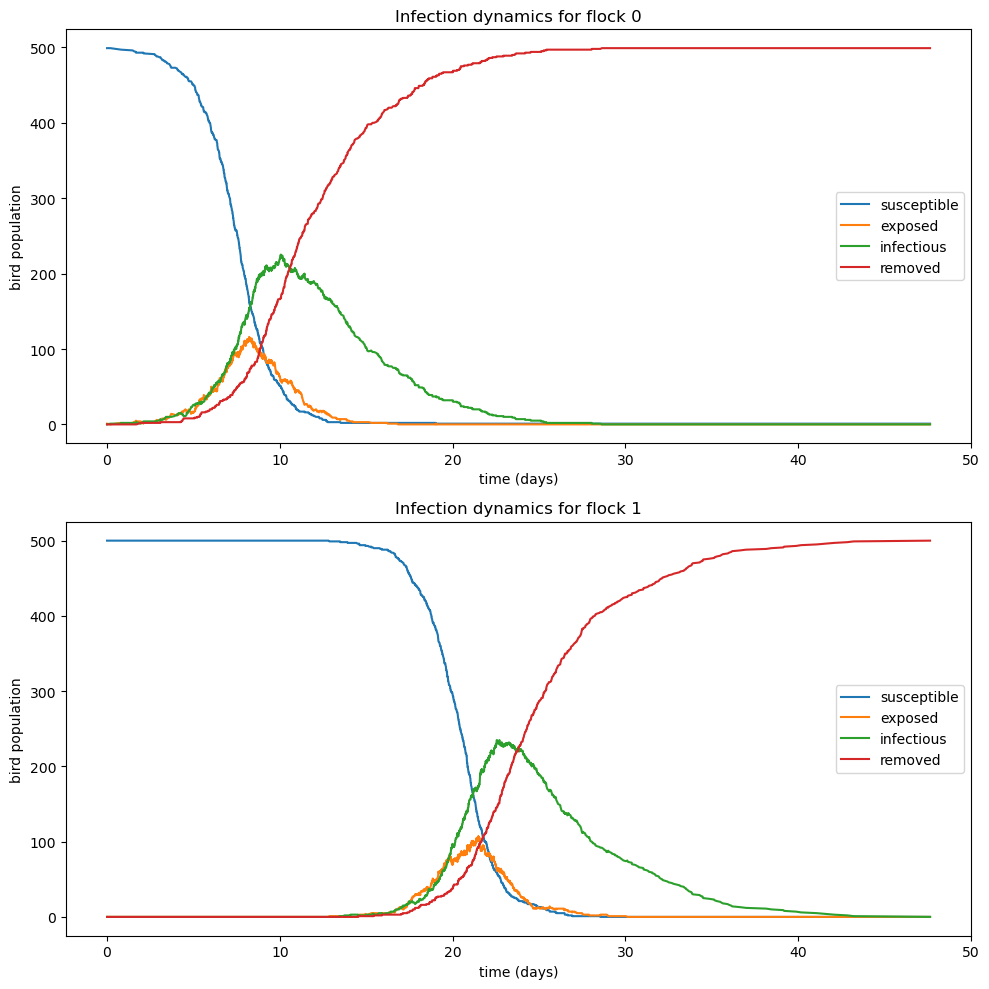

In [7]:
fig, axs = plt.subplots(num_species, 1, figsize=(10, 5*num_species))

if num_species == 1:
    axs = [axs]  # ensure axs is always iterable

for i, ax in enumerate(axs):
    # plot for bird i
    ax.plot(t, y[:, i, 0], label='susceptible')
    ax.plot(t, y[:, i, 1], label='exposed')
    ax.plot(t, y[:, i, 2], label='infectious')
    ax.plot(t, y[:, i, 3], label='removed')
    ax.legend()
    ax.set_xlabel('time (days)')
    ax.set_ylabel('bird population')
    ax.set_title(f'Infection dynamics for flock {i}')

plt.tight_layout()
plt.show()

Record key statistics:
- Whether an outbreak has occurred (Infectious population >= 10 at any point, both the population as a whole and individual flocks).
- Time of outbreak occurrence if there is an outbreak.
- The peak size of the epidemic, and when it occurred (both the population as a whole and individual flocks).
- The final size of the epidemic, and when it finished.

In [8]:
# Record key statistics

######## Outbreak statistics ########
outbreak_threshold = 10

# Outbreak or not
outbreak = len([state for state in y if np.sum(state[:,2]) >= outbreak_threshold]) > 0
outbreak = round(Decimal(outbreak), 2)

# if there is an outbreak, when does it happen
if outbreak:
    outbreak_time = t[[i for i, state in enumerate(y) if np.sum(state[:,2]) >= outbreak_threshold][0]]
    outbreak_time = round(Decimal(outbreak_time), 2)
    print(f'An outbreak has occurred, and it happened on {outbreak_time} days after the first exposure.')
else:
    outbreak_time = None
    print('An outbreak did not occur.')

# Which flocks are invaded by the virus
outbreak_indiv = [len([state for state in y if state[i,2] >= outbreak_threshold]) > 0 for i in range(num_species)]
outbreak_time_indiv = [t[[j for j, state in enumerate(y) if np.sum(state[i,2]) >= outbreak_threshold][0]] if outbreak_indiv[i] else None for i in range(num_species)]
outbreak_time_indiv = [round(Decimal(i), 2) if i != None else None for i in outbreak_time_indiv]

for i in range(num_species):
    if outbreak_indiv[i]:
        print(f'An outbreak in flock {i} occurred after {outbreak_time_indiv[i]} days')
    else:
        print(f'Outbreak did not occur in flock {i}')

An outbreak has occurred, and it happened on 3.41 days after the first exposure.
An outbreak in flock 0 occurred after 3.41 days
An outbreak in flock 1 occurred after 16.74 days


In [9]:
######## Peak size for all flocks as a whole ########
peak_size_whole = int(np.max([np.sum(state[:,2]) for state in y]))
peak_time_whole = t[np.argmax([np.sum(state[:,2]) for state in y])]
peak_time_whole = round(Decimal(peak_time_whole), 2)

print(f'The peak of the epidemic occurred after {peak_time_whole} days, with the total peak size {peak_size_whole}.')

######## Individual peak size ########
peak_size_indiv = np.amax([state[:,2] for state in y], axis=0)
peak_size_indiv = [int(i) for i in peak_size_indiv]

peak_time_indiv = [round(Decimal(t[i]), 2) for i in np.argmax([state[:,2] for state in y], axis=0)]

for i in range(num_species):
    print(f'The peak for flock {i} occurred after {peak_time_indiv[i]} days, with the flock peak size {peak_size_indiv[i]}')

The peak of the epidemic occurred after 22.55 days, with the total peak size 246.
The peak for flock 0 occurred after 10.05 days, with the flock peak size 225
The peak for flock 1 occurred after 22.55 days, with the flock peak size 235


In [10]:
######## Final size ########
final_size = y[-1][:,-1]
final_size = [int(i) for i in final_size]

end_time = t[-1]
end_time = round(Decimal(end_time), 2)

print(f'After {end_time} days:')
for i in range(num_species):
    print(f'the final number of removed birds in flock {i} is {final_size[i]}.')
    

After 47.62 days:
the final number of removed birds in flock 0 is 499.
the final number of removed birds in flock 1 is 500.
